In [126]:
# Import plotting, data analysis, and sci-kit learn libraries
import os
import datetime

import IPython
import IPython.display 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False 

In [127]:
# load streamflow data for Spokane River.

file_path = 'spokane_streamflow.csv'
df = pd.read_csv(file_path)

df = df[0::4]
df['datetime']=df['date'] + ' ' + df['time']
df = df.drop(['agency_cd', 'tz_cd', ' 219061_00065_cd', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'], axis=1)

df.head()



# df.info()

,site-no,date,time,gage_height (ft),datetime
0,12422000,10/1/17,1:00,5.82,10/1/17 1:00
4,12422000,10/1/17,2:00,5.82,10/1/17 2:00
8,12422000,10/1/17,3:00,5.82,10/1/17 3:00
12,12422000,10/1/17,4:00,5.82,10/1/17 4:00
16,12422000,10/1/17,5:00,5.82,10/1/17 5:00


In [128]:
# Calculate 30 Day Average
mvg_avg_30day = []
i = 0
avg = sum(df['gage_height (ft)'][i:i+(24*30)]) / (24*30)
while i < len(df):
    if i + (24*30) <= len(df):
        avg = sum(df['gage_height (ft)'][i:i+(24*30)]) / (24*30)
        mvg_avg_30day.append(avg)
        i += 1
    else:
        avg = sum(df['gage_height (ft)'][i:]) / ((len(df) - i ))
        mvg_avg_30day.append(avg)
        i +=1

df['30 Day Moving Avg Gage Height (ft)'] = mvg_avg_30day

df.head()

,site-no,date,time,gage_height (ft),datetime,30 Day Moving Avg Gage Height (ft)
0,12422000,10/1/17,1:00,5.82,10/1/17 1:00,6.627292
4,12422000,10/1/17,2:00,5.82,10/1/17 2:00,6.629250
8,12422000,10/1/17,3:00,5.82,10/1/17 3:00,6.631208
12,12422000,10/1/17,4:00,5.82,10/1/17 4:00,6.633181
16,12422000,10/1/17,5:00,5.82,10/1/17 5:00,6.635139


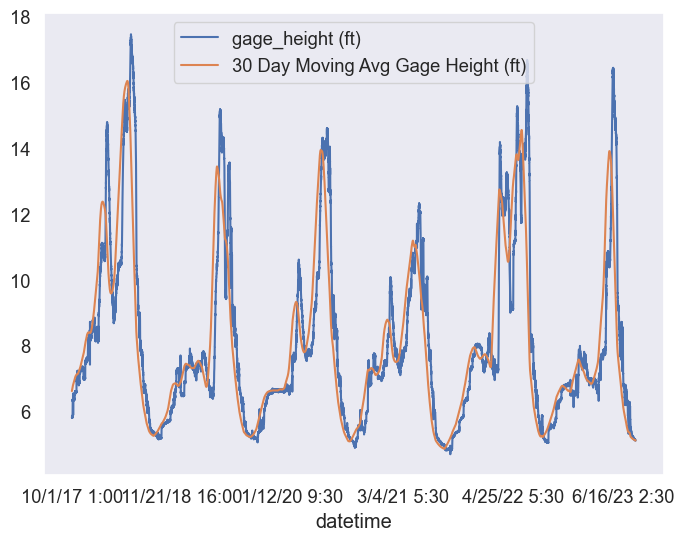

In [129]:
# Plot streamflow data and 30 day moving average

plot_cols = ['gage_height (ft)', '30 Day Moving Avg Gage Height (ft)']
plot_features = df[plot_cols]
plot_features.index = df['datetime']
_ = plot_features.plot(subplots=False)

In [130]:
# Get basic statistics on streamflow data and 30 day moving average

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
site-no,51122.0,1.242200e+07,0.000000,1.242200e+07,1.242200e+07,1.242200e+07,1.242200e+07,1.242200e+07
gage_height (ft),51122.0,8.091608e+00,2.733367,4.710000e+00,6.290000e+00,7.300000e+00,9.130000e+00,1.746000e+01
30 Day Moving Avg Gage Height (ft),51122.0,8.082859e+00,2.552305,4.873944e+00,6.253347e+00,7.337153e+00,9.333587e+00,1.604368e+01


In [131]:
# convert date time into datetime format

df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%y %H:%M')

df['month'] = df['datetime'].dt.month
# df['day'] = df['datetime'].dt.day
df['year'] = df['datetime'].dt.year

df = df.drop(['date', 'time'], axis=1)

df.tail()


,site-no,gage_height (ft),datetime,30 Day Moving Avg Gage Height (ft),month,year
204468,12422000,5.13,2023-08-01 19:15:00,5.13,8,2023
204472,12422000,5.13,2023-08-01 20:15:00,5.13,8,2023
204476,12422000,5.13,2023-08-01 21:15:00,5.13,8,2023
204480,12422000,5.13,2023-08-01 22:15:00,5.13,8,2023
204484,12422000,5.13,2023-08-01 23:15:00,5.13,8,2023


In [132]:
# check data types for usability in model

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51122 entries, 0 to 204484
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   site-no                             51122 non-null  int64         
 1   gage_height (ft)                    51122 non-null  float64       
 2   datetime                            51122 non-null  datetime64[ns]
 3   30 Day Moving Avg Gage Height (ft)  51122 non-null  float64       
 4   month                               51122 non-null  int32         
 5   year                                51122 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1)
memory usage: 2.0 MB


In [134]:


# Load and preprocess data as you did before

# Split the data into features (X) and target (y)
X = df.drop(columns=["gage_height (ft)", "30 Day Moving Avg Gage Height (ft)", "datetime"])
y = df["30 Day Moving Avg Gage Height (ft)"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=620)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an SVR regressor
svr_rbf= SVR(kernel='rbf')  
svr_linear = SVR(kernel='linear')
svr_poly = SVR(kernel='poly')

# Train the SVR model
svr_rbf.fit(X_train_scaled, y_train)
svr_linear.fit(X_train_scaled, y_train)
svr_poly.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_rbf = svr_rbf.predict(X_test_scaled)
y_pred_linear = svr_linear.predict(X_test_scaled)
y_pred_poly = svr_poly.predict(X_test_scaled)

# Evaluate the SVR model
mse_rbf = mean_squared_error(y_test, y_pred_rbf)
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_poly = mean_squared_error(y_test, y_pred_poly)

print("Mean Squared Error, RBF:", mse_rbf)
print("Mean Squared Error, Linear:", mse_linear)
print("Mean Squared Error, Poly:", mse_poly)

Mean Squared Error, RBF: 1.1479754943456009
Mean Squared Error, Linear: 5.533480521844246
Mean Squared Error, Poly: 5.900440849026504


In [135]:
# get a few more evaluation metrics for rbf, since it had the best mean squared error.

from sklearn.metrics import mean_absolute_error, mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred_rbf))
mae = mean_absolute_error(y_test, y_pred_rbf)

print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

Root Mean Squared Error: 1.071436183048529
Mean Absolute Error: 0.6692468848752777


In [136]:
# Make a table of new dates to make predictions for

present = '2023-08-01'
start_date = pd.to_datetime(present)
end_date = start_date + pd.DateOffset(years=5, months=5)

new_data = pd.DataFrame()
date_range = pd.date_range(start=start_date, end=end_date, freq='D') 

dates_df = pd.DataFrame({
    'datetime': date_range
})

new_data['month'] = dates_df['datetime'].dt.month
# new_data['day'] = dates_df['datetime'].dt.day
new_data['year'] = dates_df['datetime'].dt.year
new_data['site-no'] = '12422000'

reorder_columns = ['site-no', 'month', 'year']
new_data = new_data[reorder_columns]

new_data.tail()

,site-no,month,year
1976,12422000,12,2028
1977,12422000,12,2028
1978,12422000,12,2028
1979,12422000,12,2028
1980,12422000,1,2029


In [137]:
# Create a new DataFrame with new feature values

# Standardize the new feature data using the same scaler
new_data_scaled = scaler.transform(new_data)

# Make predictions on the new data
new_predictions = svr_rbf.predict(new_data_scaled)

# Create a new DataFrame to hold predictions
predictions_df = pd.DataFrame({
    "Predicted 30 Day Avg Gage Height (ft)": new_predictions
})

# Concatenate the new predictions with the original new_data DataFrame
predicted_data = pd.concat([new_data, predictions_df, dates_df], axis=1)

print(predicted_data)

       site-no  month  year  Predicted 30 Day Avg Gage Height (ft)   datetime
0     12422000      8  2023                               4.293598 2023-08-01
1     12422000      8  2023                               4.293598 2023-08-02
2     12422000      8  2023                               4.293598 2023-08-03
3     12422000      8  2023                               4.293598 2023-08-04
4     12422000      8  2023                               4.293598 2023-08-05
...        ...    ...   ...                                    ...        ...
1976  12422000     12  2028                              13.920098 2028-12-28
1977  12422000     12  2028                              13.920098 2028-12-29
1978  12422000     12  2028                              13.920098 2028-12-30
1979  12422000     12  2028                              13.920098 2028-12-31
1980  12422000      1  2029                              13.858583 2029-01-01

[1981 rows x 5 columns]


In [138]:
low_flow_days = predicted_data.describe()

low_flow_days

,month,year,Predicted 30 Day Avg Gage Height (ft),datetime
count,1981.000000,1981.000000,1981.000000,1981
mean,6.786976,2025.769813,7.094793,2026-04-17 00:00:00
min,1.000000,2023.000000,-3.346220,2023-08-01 00:00:00
25%,4.000000,2024.000000,3.093982,2024-12-08 00:00:00
50%,7.000000,2026.000000,7.726243,2026-04-17 00:00:00
75%,10.000000,2027.000000,12.011092,2027-08-25 00:00:00
max,12.000000,2029.000000,13.920098,2029-01-01 00:00:00
std,3.466004,1.579387,5.183758,NaN


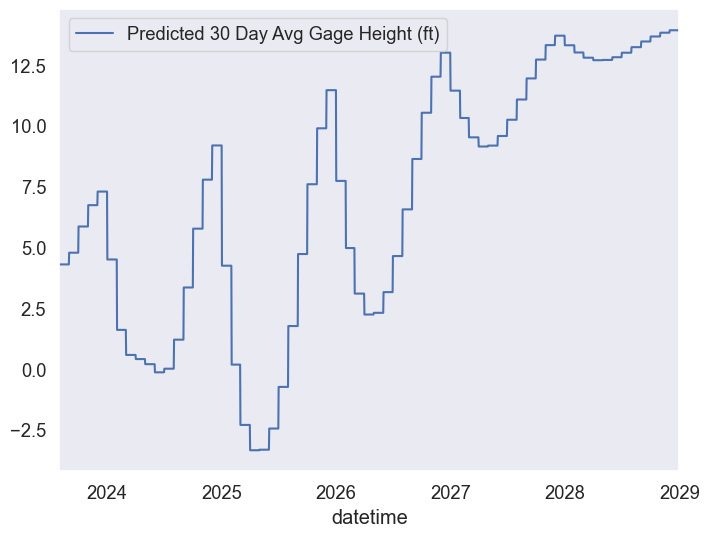

In [139]:
plot_cols = ['Predicted 30 Day Avg Gage Height (ft)']
plot_features = predicted_data[plot_cols]
plot_features.index = predicted_data['datetime']
_ = plot_features.plot(subplots=False)

In [183]:
# Taking the minimum of the last several years as the "low flow value"
# This value needs additional statistical validation and should be replaced in the future

threshold_value = 4.873944
low_flow_count = predicted_data[predicted_data['Predicted 30 Day Avg Gage Height (ft)'] < threshold_value].shape[0]
annualized_lfc = low_flow_count / (predicted_data.shape[0]/365)

print("Count of values below the threshold:", low_flow_count)
print("Expected annual low flow count days:", annualized_lfc)


Count of values below the threshold: 761
Expected annual low flow count days: 140.21453811206462


In [140]:
file_path = 'data/17irs_wa.csv'
irs17 = pd.read_csv(file_path)
irs17.dropna(inplace=True)

irs17.head(20)

,ZIP\ncode [1],Size of adjusted gross income,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number of individuals,Number of electronically filed returns,Number of computer prepared paper returns,Number with paid preparer's signature,Number of returns with direct deposit,Number of exemptions,Number of dependent exemptions,Number of refund anticipation check returns [3],Elderly returns,Adjusted gross income (AGI) [5],Farm returns,Unemployment compensation [7] - Number of returns,Taxable Social Security benefits - Number of returns,Partnership/S-corp net income (less loss) - Number of returns
0,0,Total,3523830,1701350,1395810,377750,5601260,3102190,203070,1437800,2164220,6809430,2077430,395470,855800,296774205,19000,145330,519140,206540
1,0,"$1 under $25,000",973730,726850,110780,123850,1294820,833450,61800,334650,617880,1225850,321090,119740,199990,12408658,3290,28500,49590,15550
2,0,"$25,000 under $50,000",836560,486020,189820,145800,1326650,741270,45500,309430,597310,1508870,490090,133610,168100,30552853,3320,41020,125600,20180
3,0,"$50,000 under $75,000",529490,243350,219110,57990,868020,466990,29520,218290,345380,1086090,338530,66760,143460,32648214,3930,28650,107700,22640
4,0,"$75,000 under $100,000",364060,111180,222600,25080,615270,322460,19660,158930,226750,838370,251210,36040,110790,31601231,2260,18770,83160,21170
5,0,"$100,000 under $200,000",586200,107070,454560,20930,1042370,524490,34040,271830,310150,1496530,456170,36670,171160,80253548,5300,24710,117940,59730
6,0,"$200,000 or more",233790,26880,198940,4100,454130,213530,12550,144670,66750,653720,220340,2650,62300,109309701,900,3680,35150,67270
8,98001,"$1 under $25,000",4290,3250,490,510,5630,3720,270,1720,2750,5140,1340,470,670,53379,20,110,170,80
9,98001,"$25,000 under $50,000",3950,2340,840,680,6290,3540,210,1660,2870,7080,2340,620,650,144719,0,150,430,140
10,98001,"$50,000 under $75,000",2730,1190,1150,340,4660,2400,150,1230,1820,5810,1930,360,640,168848,0,140,440,130


In [141]:
file_path = 'data/18irs_wa.csv'
irs18 = pd.read_csv(file_path)
irs18.dropna(inplace=True)

irs18.head(20)

,ZIP\ncode [1],Size of adjusted gross income,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number of individuals,Number of dependents,Elderly returns,Adjusted gross income (AGI) [6],Business or profession - Number of returns\nnet income (less loss),Farm returns,Unemployment compensation [8],Taxable Social Security benefits,Partnership/S-corp net income (less loss),Self-employment tax
0,0.0,Total,3579250,1738880,1411360,375590,6821800,2024790,882900,326628023,489950,18550,131410,543580,209300,390910
1,0.0,"$1 under $25,000",917680,693700,100720,110450,1123620,281000,193020,11770347,118310,2800,23650,50130,14420,99320
2,0.0,"$25,000 under $50,000",841340,502710,175410,146810,1454180,449120,167600,30781842,89920,3070,35780,124250,18930,69470
3,0.0,"$50,000 under $75,000",542860,260790,209860,62020,1072540,321790,146530,33473947,68180,3860,26070,109640,21870,51970
4,0.0,"$75,000 under $100,000",375730,123500,219510,27370,843690,248790,114910,32614295,53640,2050,17550,86650,20200,40090
5,0.0,"$100,000 under $200,000",627660,123680,475390,24090,1575820,474050,187870,86306580,104910,5740,24410,130820,60310,80400
6,0.0,"$200,000 or more",273980,34500,230470,4850,751950,250040,72970,131681012,54990,1030,3950,42090,73570,49660
9,98001.0,"$1 under $25,000",3990,3070,450,420,4610,1140,660,50371,670,0,90,170,70,570
10,98001.0,"$25,000 under $50,000",4050,2410,840,700,7110,2280,690,149387,540,0,140,450,120,440
11,98001.0,"$50,000 under $75,000",2720,1220,1040,390,5630,1880,600,167372,390,0,110,410,140,290


In [142]:
file_path = 'data/19irs_wa.csv'
irs19 = pd.read_csv(file_path)
irs19.dropna(inplace=True)

irs19.head(20)

,ZIP\ncode [1],Size of adjusted gross income,Number of returns [2],Number of single returns,Number of joint returns,Number of head of household returns,Number of individuals,Elderly returns,Business or profession\nnet income (less loss),Farm returns,Unemployment compensation [9],Taxable Social Security benefits,Partnership/S-corp net income (less loss)
0,0,Total,3704660.0,1839290.0,1422870.0,381490.0,6936180.0,904980.0,498890.0,17910.0,137300.0,558760.0,207150.0
1,0,"$1 under $25,000",931500.0,714700.0,97110.0,105270.0,1116250.0,191870.0,121520.0,2750.0,22510.0,51540.0,13740.0
2,0,"$25,000 under $50,000",861980.0,530250.0,165490.0,147820.0,1443360.0,169300.0,90500.0,2960.0,37880.0,124000.0,17950.0
3,0,"$50,000 under $75,000",562230.0,282310.0,201320.0,66930.0,1074470.0,148860.0,67710.0,3640.0,27030.0,110650.0,20830.0
4,0,"$75,000 under $100,000",385270.0,134330.0,214890.0,29590.0,843480.0,117730.0,52980.0,1860.0,18840.0,88580.0,19630.0
5,0,"$100,000 under $200,000",662580.0,139290.0,491370.0,26370.0,1634110.0,199890.0,107600.0,5720.0,26610.0,139720.0,59700.0
6,0,"$200,000 or more",301100.0,38410.0,252690.0,5510.0,824510.0,77330.0,58580.0,980.0,4430.0,44270.0,75300.0
9,98001,"$1 under $25,000",4110.0,3150.0,460.0,430.0,4770.0,690.0,690.0,0.0,70.0,190.0,70.0
10,98001,"$25,000 under $50,000",4060.0,2520.0,770.0,680.0,6820.0,670.0,550.0,0.0,120.0,430.0,120.0
11,98001,"$50,000 under $75,000",2940.0,1390.0,1040.0,430.0,5840.0,670.0,410.0,0.0,110.0,450.0,140.0


In [143]:
file_path = 'data/20irs_wa.csv'
irs20 = pd.read_csv(file_path)
irs20.dropna(inplace=True)

irs20.head(20)

,ZIP\ncode [1],Size of adjusted gross income,Number of returns [2],Number of single returns,Number of joint returns,Number of head of household returns,Number of individuals,Elderly returns,Farm returns,Unemployment compensation [9],Taxable Social Security benefits,Partnership/S-corp net income (less loss)
0,0.0,Total,3729600.0,1882860.0,1413550.0,369430.0,6904690.0,929640.0,17350.0,820680.0,569460.0,204060.0
1,0.0,"$1 under $25,000",900860.0,700580.0,96790.0,88910.0,1100670.0,207170.0,2520.0,169650.0,59120.0,14350.0
2,0.0,"$25,000 under $50,000",877940.0,552010.0,159710.0,148280.0,1429340.0,175820.0,2720.0,247420.0,128960.0,18450.0
3,0.0,"$50,000 under $75,000",569560.0,295070.0,194710.0,67920.0,1055390.0,151720.0,3390.0,134270.0,112090.0,20550.0
4,0.0,"$75,000 under $100,000",387710.0,140370.0,208930.0,30700.0,828040.0,118030.0,2100.0,90910.0,87960.0,19000.0
5,0.0,"$100,000 under $200,000",665260.0,146850.0,484170.0,27460.0,1612030.0,197840.0,5490.0,141320.0,137380.0,56650.0
6,0.0,"$200,000 or more",328270.0,47980.0,269240.0,6160.0,879220.0,79060.0,1130.0,37110.0,43950.0,75060.0
9,98001.0,"$1 under $25,000",3990.0,3070.0,460.0,390.0,4960.0,750.0,20.0,880.0,210.0,80.0
10,98001.0,"$25,000 under $50,000",4210.0,2560.0,810.0,710.0,7100.0,690.0,0.0,1360.0,450.0,120.0
11,98001.0,"$50,000 under $75,000",2950.0,1470.0,1000.0,410.0,5660.0,650.0,0.0,780.0,420.0,130.0


In [144]:
col_count = {'17': irs17.shape[1],
             '18': irs18.shape[1],
             '19': irs19.shape[1],
             '20': irs20.shape[1]}

col_count

{'17': 20, '18': 16, '19': 13, '20': 12}

In [145]:
df_headings = [irs17.columns.tolist(), irs18.columns.tolist(), irs19.columns.tolist(), irs20.columns.tolist()]
print(df_headings)

irs17['Year'] = 2017
irs18['Year'] = 2018
irs19['Year'] = 2019
irs20['Year'] = 2020

selected_columns = ['Year', 'ZIP\ncode [1]', 'Size of adjusted gross income', 'Number of individuals', 'Elderly returns', 'Farm returns']

irs17 = pd.DataFrame(irs17[selected_columns])
irs18 = pd.DataFrame(irs18[selected_columns])
irs19 = pd.DataFrame(irs19[selected_columns])
irs20 = pd.DataFrame(irs20[selected_columns])

df = pd.concat([irs17, irs18, irs19, irs20])

df

[['ZIP\ncode [1]', 'Size of adjusted gross income', 'Number of returns', 'Number of single returns', 'Number of joint returns', 'Number of head of household returns', 'Number of individuals', 'Number of electronically filed returns', 'Number of computer prepared paper returns', "Number with paid preparer's signature", 'Number of returns with direct deposit', 'Number of exemptions', 'Number of dependent exemptions', 'Number of refund anticipation check returns [3]', 'Elderly returns', 'Adjusted gross income (AGI) [5]', 'Farm returns', 'Unemployment compensation [7] - Number of returns', 'Taxable Social Security benefits - Number of returns', 'Partnership/S-corp net income (less loss) - Number of returns'], ['ZIP\ncode [1]', 'Size of adjusted gross income', 'Number of returns', 'Number of single returns', 'Number of joint returns', 'Number of head of household returns', 'Number of individuals', 'Number of dependents', 'Elderly returns', 'Adjusted gross income (AGI) [6]', 'Business or pro

,Year,ZIP\ncode [1],Size of adjusted gross income,Number of individuals,Elderly returns,Farm returns
0,2017,0,Total,5601260,855800,19000
1,2017,0,"$1 under $25,000",1294820,199990,3290
2,2017,0,"$25,000 under $50,000",1326650,168100,3320
3,2017,0,"$50,000 under $75,000",868020,143460,3930
4,2017,0,"$75,000 under $100,000",615270,110790,2260
...,...,...,...,...,...,...
4002,2020,99999.0,"$25,000 under $50,000",23430.0,4090.0,80.0
4003,2020,99999.0,"$50,000 under $75,000",16270.0,3540.0,70.0
4004,2020,99999.0,"$75,000 under $100,000",11760.0,2590.0,60.0
4005,2020,99999.0,"$100,000 under $200,000",19940.0,3950.0,160.0


In [146]:
file_path = 'data/zip_code_database.csv'
zip_codes = pd.read_csv(file_path)

zip_codes.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population
0,501,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787, 939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787, 939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,"787, 939",NaN,US,18.43,-67.15,0


In [149]:
df['Size of adjusted gross income'] = pd.factorize(df['Size of adjusted gross income'])[0]

for col in df:
    df[col] = df[col].replace(',', '')
    df[col] = df[col].replace('** ', np.nan)

df.dropna(inplace=True)

df = df.astype(int)


df

,Year,ZIP\ncode [1],Size of adjusted gross income,Number of individuals,Elderly returns,Farm returns
0,2017,0,0,5601260,855800,19000
1,2017,0,1,1294820,199990,3290
2,2017,0,2,1326650,168100,3320
3,2017,0,3,868020,143460,3930
4,2017,0,4,615270,110790,2260
...,...,...,...,...,...,...
4002,2020,99999,2,23430,4090,80
4003,2020,99999,3,16270,3540,70
4004,2020,99999,4,11760,2590,60
4005,2020,99999,5,19940,3950,160


In [150]:
file_path = 'data/zip_code_database.csv'
zip_codes = pd.read_csv(file_path)

zip_codes.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population
0,501,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Internal Revenue Service,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787, 939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787, 939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,"787, 939",NaN,US,18.43,-67.15,0


In [151]:
zip_columns = ["zip", "state", "county"]

zip_codes = zip_codes[zip_columns]

zip_filter = zip_codes.query("county == 'Spokane County'")

zip_filter

,zip,state,county
42293,99001,WA,Spokane County
42294,99003,WA,Spokane County
42295,99004,WA,Spokane County
42296,99005,WA,Spokane County
42297,99006,WA,Spokane County
42299,99009,WA,Spokane County
42300,99011,WA,Spokane County
42301,99012,WA,Spokane County
42303,99014,WA,Spokane County
42304,99016,WA,Spokane County


In [152]:
spokane_zips = zip_filter['zip'].tolist()

spokane_zips

[99001,
 99003,
 99004,
 99005,
 99006,
 99009,
 99011,
 99012,
 99014,
 99016,
 99018,
 99019,
 99020,
 99021,
 99022,
 99023,
 99025,
 99027,
 99030,
 99031,
 99036,
 99037,
 99039,
 99201,
 99202,
 99203,
 99204,
 99205,
 99206,
 99207,
 99208,
 99209,
 99210,
 99211,
 99212,
 99213,
 99214,
 99215,
 99216,
 99217,
 99218,
 99219,
 99220,
 99223,
 99224,
 99228,
 99251,
 99252,
 99256,
 99258,
 99260,
 99299]

In [153]:
df_spokane = df[df['ZIP\ncode [1]'].isin(spokane_zips)]

df_spokane

,Year,ZIP\ncode [1],Size of adjusted gross income,Number of individuals,Elderly returns,Farm returns
2619,2017,99001,1,1760,170,0
2620,2017,99001,2,1470,90,0
2621,2017,99001,3,660,70,0
2622,2017,99001,4,350,30,0
2623,2017,99001,5,290,30,0
...,...,...,...,...,...,...
3746,2020,99224,2,4620,600,0
3747,2020,99224,3,3250,480,30
3748,2020,99224,4,2580,420,0
3749,2020,99224,5,5210,650,60


In [154]:
df_spokane['Total Population'] = df_spokane.groupby(['Year', 'ZIP\ncode [1]'])['Number of individuals'].transform('sum')
df_spokane['Population Fraction'] = df_spokane['Number of individuals'] / df_spokane['Total Population']

df_spokane

/var/folders/lz/688vwzb10dl5n38_qdr537lr0000gn/T/ipykernel_40767/654951349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spokane['Total Population'] = df_spokane.groupby(['Year', 'ZIP\ncode [1]'])['Number of individuals'].transform('sum')
/var/folders/lz/688vwzb10dl5n38_qdr537lr0000gn/T/ipykernel_40767/654951349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spokane['Population Fraction'] = df_spokane['Number of individuals'] / df_spokane['Total Population']


,Year,ZIP\ncode [1],Size of adjusted gross income,Number of individuals,Elderly returns,Farm returns,Total Population,Population Fraction
2619,2017,99001,1,1760,170,0,4550,0.386813
2620,2017,99001,2,1470,90,0,4550,0.323077
2621,2017,99001,3,660,70,0,4550,0.145055
2622,2017,99001,4,350,30,0,4550,0.076923
2623,2017,99001,5,290,30,0,4550,0.063736
...,...,...,...,...,...,...,...,...
3746,2020,99224,2,4620,600,0,21730,0.212609
3747,2020,99224,3,3250,480,30,21730,0.149563
3748,2020,99224,4,2580,420,0,21730,0.118730
3749,2020,99224,5,5210,650,60,21730,0.239761


In [155]:
df_low_income = df_spokane[df_spokane['Size of adjusted gross income'] == 1]
df_low_income = df_low_income[df_low_income['Year'] == 2020]
df_low_income['Deviation from Normal Distribution'] = (df_low_income['Population Fraction'] - 0.2)/0.2

df_low_income

,Year,ZIP\ncode [1],Size of adjusted gross income,Number of individuals,Elderly returns,Farm returns,Total Population,Population Fraction,Deviation from Normal Distribution
3033,2020,99001,1,2110,160,0,6530,0.323124,0.615620
3041,2020,99003,1,880,210,0,5300,0.166038,-0.169811
3049,2020,99004,1,3600,450,0,17110,0.210403,0.052016
3057,2020,99005,1,1210,250,0,10370,0.116683,-0.416586
3065,2020,99006,1,2320,530,30,13230,0.175359,-0.123205
3081,2020,99009,1,700,170,20,3690,0.189702,-0.051491
3089,2020,99011,1,460,0,0,2260,0.203540,0.017699
3097,2020,99012,1,160,40,0,930,0.172043,-0.139785
3113,2020,99016,1,2350,600,0,17830,0.131800,-0.340998
3121,2020,99018,1,50,0,0,220,0.227273,0.136364


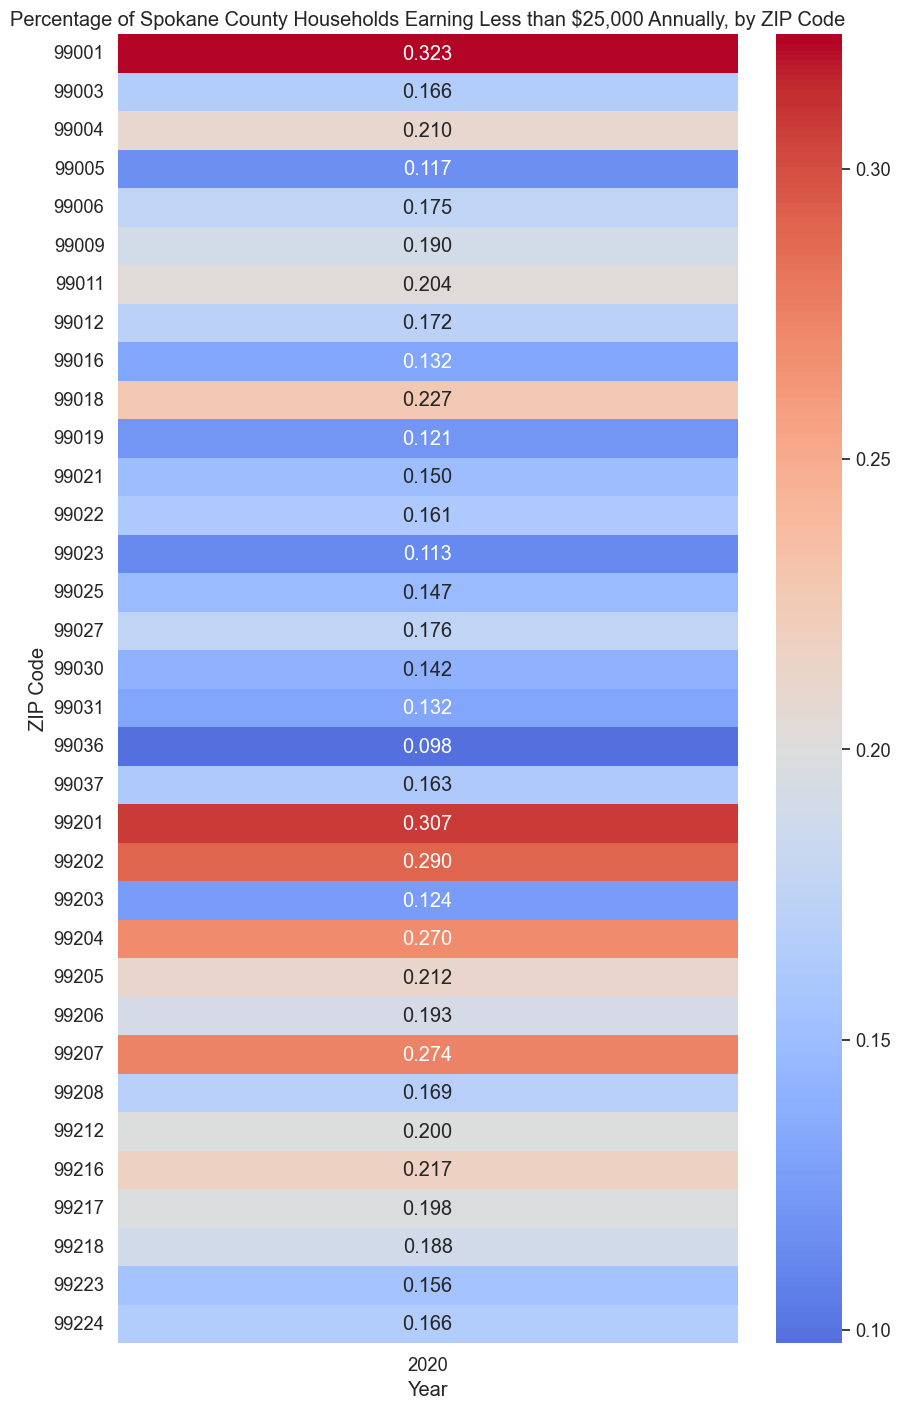

In [156]:
heatmap_data = df_low_income.pivot(index='ZIP\ncode [1]', columns='Year', values='Population Fraction')

fig_height = max(len(heatmap_data) * 0.5, 6)

# Set up the figure size
plt.figure(figsize=(10, fig_height))

# Create the heatmap
sns.heatmap(data=heatmap_data, 
            cmap='coolwarm', 
            annot=True, 
            fmt='.3f', 
            cbar=True,
            center=0.2)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('ZIP Code')
plt.title('Percentage of Spokane County Households Earning Less than $25,000 Annually, by ZIP Code')

plt.show()

In [158]:
df_low_income_summary = df_low_income.describe()

df_low_income_summary

,Year,ZIP\ncode [1],Size of adjusted gross income,Number of individuals,Elderly returns,Farm returns,Total Population,Population Fraction,Deviation from Normal Distribution
count,34.0,34.000000,34.0,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,2020.0,99097.117647,1.0,2559.117647,485.294118,5.000000,13552.058824,0.184751,-0.076244
std,0.0,96.726345,0.0,2329.033312,446.781319,10.224747,11998.583194,0.056094,0.280468
min,2020.0,99001.000000,1.0,50.000000,0.000000,0.000000,220.000000,0.097701,-0.511494
25%,2020.0,99016.500000,1.0,782.500000,170.000000,0.000000,5082.500000,0.148050,-0.259750
50%,2020.0,99030.500000,1.0,2215.000000,420.000000,0.000000,11475.000000,0.173701,-0.131495
75%,2020.0,99205.750000,1.0,3607.500000,665.000000,0.000000,18422.500000,0.208687,0.043437
max,2020.0,99224.000000,1.0,8800.000000,1790.000000,30.000000,52220.000000,0.323124,0.615620


In [162]:
low_income_total = df_low_income['Number of individuals'].sum()

low_income_total

87010

In [185]:
print("{} low-income people in Spokane County, WA may face water restrictions and potential shortages {} days per year before 2029.".format(low_income_total, annualized_lfc))

87010 low-income people in Spokane County, WA may face water restrictions and potential shortages 140.21453811206462 days per year before 2029.
